**About** : This notebook is used to train models.


In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/theo/Documents/sartorius/src


## Initialization

### Imports

In [3]:
import os
import sys
import cv2
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
warnings.simplefilter("ignore", UserWarning)

In [4]:
from params import *

from utils.plots import *
from utils.metrics import iou_map
from utils.rle import rles_to_mask_fix
from utils.logger import prepare_log_folder, create_logger, save_config

from data.preparation import prepare_data
from data.transforms import get_transfos, get_transfos_inference
from data.dataset import SartoriusDataset

from training.main import k_fold
from inference.post_process import *

## Data

In [5]:
df = prepare_data(width=1)


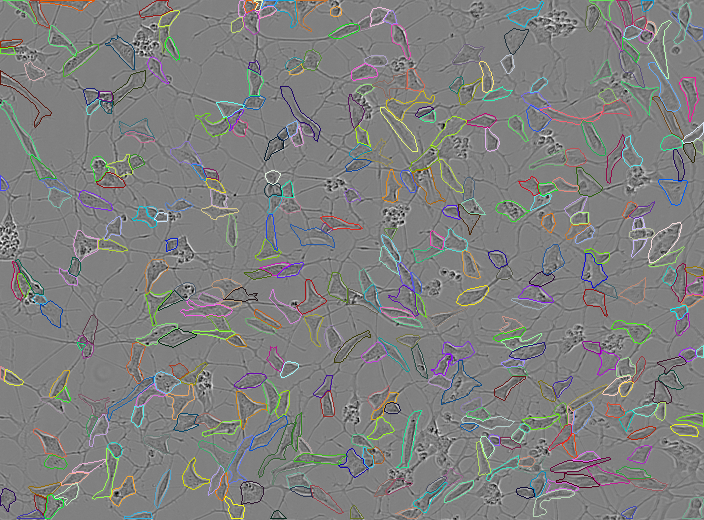

In [6]:
idx = 0

dataset_plot = SartoriusDataset(df)
img, masks, y = dataset_plot[idx]


mask = masks[..., 0]
fig = plot_sample(img, mask, plotly=True)

fig.update_layout(
    autosize=False,
    width=900,
    height=800,
)

fig.show()

In [7]:
transforms = get_transfos(augment=True, visualize=True)
dataset = SartoriusDataset(df, transforms=transforms)

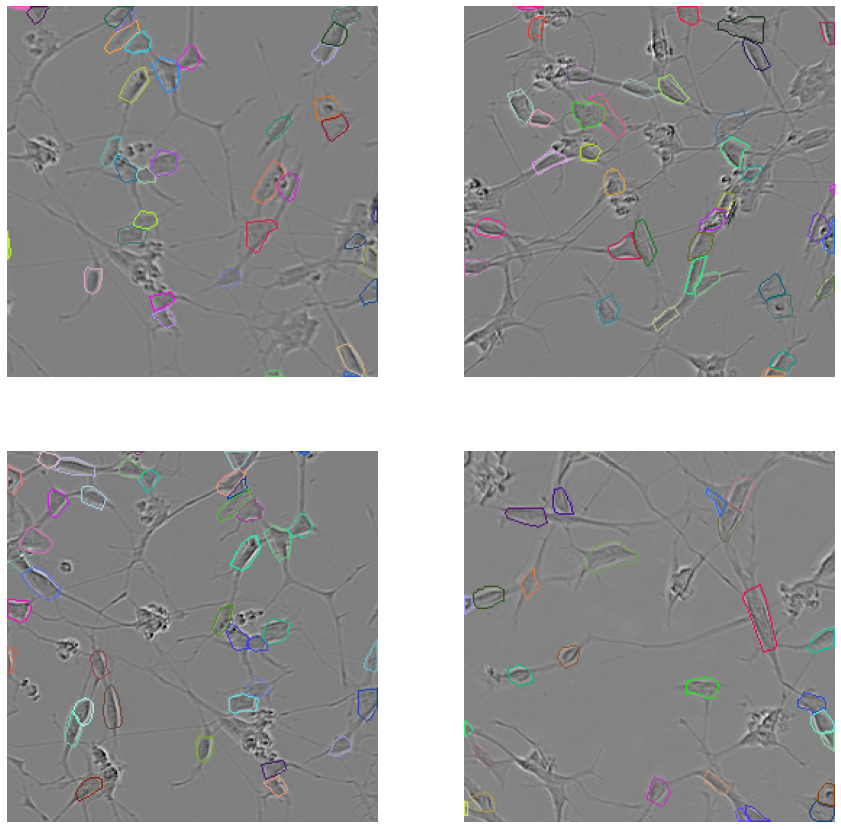

In [8]:
plt.figure(figsize=(15, 15))

for i in range(4):
    plt.subplot(2, 2, i + 1)
#     idx = np.random.choice(len(dataset))
    idx = 188
    img, masks, y = dataset[idx]

    try:
        img = img.numpy().transpose(1, 2, 0)
        mask = masks[0].numpy().astype(int)
        plot_sample(img, mask)
    except AttributeError:
        plot_sample(img, mask)

    plt.axis(False)
plt.show()

## Model

In [9]:
from model_zoo.models import define_model
from training.optim import SartoriusLoss

In [10]:
model = define_model(
    "Unet",
    "resnet18",
    num_classes=3,
    num_classes_cls=3,
    encoder_weights="imagenet",
    reduce_stride=True
)

In [11]:
x = torch.rand(1, 3, 256, 256)
mask, y = model(x)

mask.size(), y.size()

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3]))

In [12]:
y = torch.tensor([2])
p = torch.tensor([[0, 0.7, .5]])

In [13]:
(p.argmax(1) == y).sum()

tensor(0)

In [14]:
cfg = {"w_bce": (0, 0, 1), "w_lovasz": (1, 0, 0), "w_focal": (0, 0, 1), "w_dice": (0, 1, 0), "w_seg_loss": 1}
loss = SartoriusLoss(cfg)

In [15]:
y_mask, y_cls, _ = dataset[0]

In [16]:
# loss(mask, y, y_mask.unsqueeze(0).float(), y_cls.unsqueeze(0).float())

## Training

In [17]:
BATCH_SIZES = {
    "resnet18": 32,
    "resnet34": 32,
    "resnext50_32x4d": 32,
    "se_resnext50_32x4d": 32,
    "efficientnet-b0": 32,
    "efficientnet-b1": 32,
    "efficientnet-b2": 32,
    "efficientnet-b3": 16,
    "efficientnet-b4": 16,
    "efficientnet-b5": 16,
    "efficientnet-b6": 8,
}

In [18]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    first_epoch_eval = 0

    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # Images
    size = 256
    size_val = 512
    use_tta = True
    width = 2

    # k-fold
    k = 5
    random_state = 0
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    encoder = "resnext50_32x4d"  # "resnet18" "resnext50_32x4d", "resnet34", "efficientnet-b5"
    decoder = "Unet"
    encoder_weights = "imagenet"
    num_classes = 3
    num_classes_cls = 3
    reduce_stride = True

    # Training
    activations = {
        "cls": "softmax", 
        "mask": "sigmoid", 
        "contour": "sigmoid", 
        "dist": "sigmoid",
    }

    optimizer = "Adam"
    loss_config = {
        "w_bce": (0, 1, 1),
        "w_lovasz": (1, 0, 0),
        "w_focal": (0, 0, 0),
        "w_dice": (0, 0, 0),
        "w_seg_loss": 0.999
    }

    batch_size = BATCH_SIZES[encoder]
    val_bs = batch_size

    if reduce_stride:
        batch_size = batch_size // 2
        val_bs = batch_size // 2

    epochs = 40 if batch_size >= 32 else 30

    lr = 1e-3
    warmup_prop = 0.05

In [19]:
DEBUG = False
log_folder = None

In [20]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")

preds, preds_instance, truths = k_fold(Config, log_folder=log_folder)

Logging results to ../logs/2021-10-24/2/

-------------   Fold 1 / 5  -------------

    -> 484 training images
    -> 122 validation images
    -> 31999414 trainable parameters

Epoch 01/30 	 lr=6.7e-04	 t=26s	loss=1.201	val_loss=1.586 	 dice=0.387 	acc=0.877
Epoch 02/30 	 lr=9.8e-04	 t=26s	loss=0.765	val_loss=0.591 	 dice=0.636 	acc=0.951
Epoch 03/30 	 lr=9.5e-04	 t=26s	loss=0.571	val_loss=0.501 	 dice=0.696 	acc=0.893
Epoch 04/30 	 lr=9.1e-04	 t=26s	loss=0.487	val_loss=0.425 	 dice=0.755 	acc=0.902
Epoch 05/30 	 lr=8.8e-04	 t=26s	loss=0.465	val_loss=0.451 	 dice=0.716 	acc=0.697
Epoch 06/30 	 lr=8.4e-04	 t=26s	loss=0.435	val_loss=0.386 	 dice=0.757 	acc=0.992
Epoch 07/30 	 lr=8.1e-04	 t=26s	loss=0.437	val_loss=0.382 	 dice=0.765 	acc=0.992
Epoch 08/30 	 lr=7.7e-04	 t=26s	loss=0.426	val_loss=0.381 	 dice=0.764 	acc=0.918
Epoch 09/30 	 lr=7.4e-04	 t=26s	loss=0.411	val_loss=0.361 	 dice=0.775 	acc=0.992
Epoch 10/30 	 lr=7.0e-04	 t=26s	loss=0.395	val_loss=0.358 	 dice=0.775 	acc=1.000
E

    -> 485 training images
    -> 121 validation images
    -> 31999414 trainable parameters

Epoch 01/30 	 lr=6.7e-04	 t=26s	loss=1.210	val_loss=0.912 	 dice=0.421 	acc=0.802
Epoch 02/30 	 lr=9.8e-04	 t=26s	loss=0.762	val_loss=0.592 	 dice=0.638 	acc=0.802
Epoch 03/30 	 lr=9.5e-04	 t=26s	loss=0.556	val_loss=0.519 	 dice=0.669 	acc=0.934
Epoch 04/30 	 lr=9.1e-04	 t=26s	loss=0.467	val_loss=0.415 	 dice=0.741 	acc=0.992
Epoch 05/30 	 lr=8.8e-04	 t=26s	loss=0.453	val_loss=0.493 	 dice=0.694 	acc=0.702
Epoch 06/30 	 lr=8.4e-04	 t=26s	loss=0.444	val_loss=0.409 	 dice=0.734 	acc=0.967
Epoch 07/30 	 lr=8.1e-04	 t=26s	loss=0.421	val_loss=0.385 	 dice=0.756 	acc=0.967
Epoch 08/30 	 lr=7.7e-04	 t=26s	loss=0.424	val_loss=0.392 	 dice=0.746 	acc=0.934
Epoch 09/30 	 lr=7.4e-04	 t=26s	loss=0.407	val_loss=0.382 	 dice=0.755 	acc=0.950
Epoch 10/30 	 lr=7.0e-04	 t=26s	loss=0.411	val_loss=0.379 	 dice=0.754 	acc=0.992
Epoch 11/30 	 lr=6.7e-04	 t=26s	loss=0.400	val_loss=0.375 	 dice=0.762 	acc=0.893
Epoc

## Viz

In [ ]:
config = Config

skf = StratifiedKFold(n_splits=config.k, shuffle=True, random_state=config.random_state)
splits = list(skf.split(X=df, y=df["cell_type"]))

all_preds, all_truths = [], []

for i, (train_idx, val_idx) in enumerate(splits):
    if i in config.selected_folds:
        df_val = df.iloc[val_idx].copy().reset_index(drop=True)
        dataset = SartoriusDataset(df_val,transforms=None)
        break

In [ ]:
PLOT = True

In [ ]:
new_preds_i = []
scores = []
types = []

for i, (pred, pred_i, truth) in tqdm(enumerate(zip(preds, preds_instance, truths))):
    cell_type = df_val['cell_type'][i]
    
    pred = np.array(pred)
    if cell_type == "shsy5y":
#         continue
        pred_i2 = post_process_shsy5y(pred)
        pred_i2 = remove_small_components(pred_i2, 100, 0)
        
    
    elif cell_type == "cort":
#         continue
        pred_i2 = post_process_cort(pred)
        pred_i2 = remove_small_components(pred_i2, 50, 0)
            
    else:
        pred_i2 = post_process_astro(pred)
        pred_i2 = remove_small_components(pred_i2, 300, 0)
    
    new_preds_i.append(pred_i2)
    
    score = iou_map([truth], [pred_i2], verbose=0)
    
    
    if PLOT:
        score_ref = iou_map([truth], [pred_i], verbose=0)
        if score < 0.1:
            continue

        score = iou_map([truth], [pred_i2], verbose=1)

    scores.append(score)
    types.append(cell_type)
    
    if PLOT:
        img, _, _ = dataset[i]

    #     plt.figure(figsize=(15, 15))
    #     plt.imshow(img)
    #     plt.axis(False)
    #     plt.title('Image')
    #     plt.show()

#         plt.figure(figsize=(15, 15))
#         plot_sample(distance, truth)
# #         plt.imshow(distance)
#         plt.axis(False)
#         plt.title('Image')
#         plt.show()

        plt.figure(figsize=(15, 15))
        plot_sample(img, truth)
        plt.axis(False)
        plt.title(f'Truth - {cell_type}')
        plt.show()

#         plt.figure(figsize=(15, 15))
#         plot_sample(img, pred_i)
#         plt.axis(False)
#         plt.title('Pred')
#         plt.show()

        plt.figure(figsize=(15, 15))
        plot_sample(img, pred_i2)
        plt.axis(False)
        plt.title(f'Pred - map_iou= {score:.3f}')
        plt.show()

#         if i > 10:
        break

In [ ]:
fig = plot_preds_iou(img, pred_i2, truth)

fig.update_layout(
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [ ]:
types = np.array(types)
scores = np.array(scores)

for t in np.unique(types):
    print(f'Avg score for {t} : {np.mean(scores[types == t]) :.3f}')